Paper replicating: replicating ViT (Vision Transformer) architecture with pytorch

In [6]:


import torch
import torchvision
import torchinfo

In [7]:
#get_data
from helper_functions import download_data
image_path=download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                         destination='pizza_steak_sushi')

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [8]:
#create dataloaders

from going_modular import data_setup
from torchvision import transforms

img_size=224 #size required for ViT

manual_transforms=transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),])


train_dataloader,test_data_loader,class_names=data_setup.create_dataloaders(train_dir='data/pizza_steak_sushi/train',
                              test_dir='data/pizza_steak_sushi/test',
                              batch_size=32,
                              transform=manual_transforms)

len(train_dataloader), len(test_data_loader), class_names



(8, 3, ['pizza', 'steak', 'sushi'])

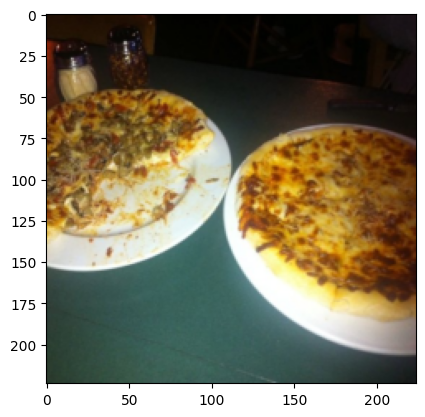

In [9]:
#visualize single image

import matplotlib.pyplot as plt

image=train_dataloader.dataset[0][0]
image_class=train_dataloader.dataset[0][1]
plt.imshow(image.permute(1,2,0))

Replicating ViT 

inputs -> outputs(image classification labels)

layers --> manipulate with example

blocks -> collection of layer

model --> collection of blocks



PSEUDOCODE:

#eq1:

x_input=[class_token,image_patch_1,image_patch_2,...image_patch_n] +
         [class_token_pos,image_patch1_pos,image_patch2_pos...image_patch_n_pos]

#eq2
X_OUTPUT_MSA_BLOCK = MSA_layer(layer_norm(x_input))+x_input(addition of 
                     residuals)

#eq3
x_output_mlp_block=MLP_Layer(LN_layer(x_output_MSA_block))+ x_output_msa_block

y=linear_layer(LN_Layer(x_output_mlp_block))

In [10]:
#step 1 - put into patches and creating class, position , patch embeddings


input_shape=(3,224,224)

embedding_size=(224*224)//(16*16) 
 
input_shape,(embedding_size,768)
#768 => hidden size

((3, 224, 224), (196, 768))

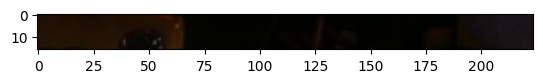

In [11]:
#get top row of image
image_permuted=image.permute(1,2,0)

patch_size=16
plt.Figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[0:patch_size,:,:])


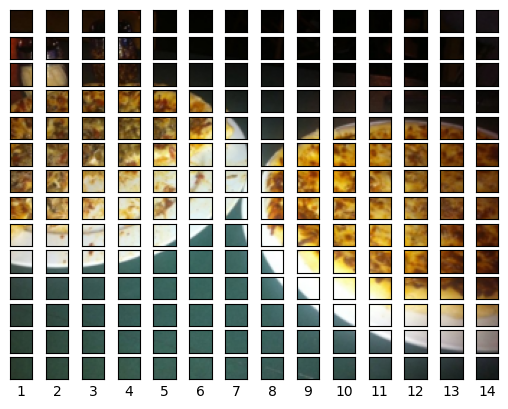

In [12]:
img_size=224
patch_size=16
num_patches=img_size//patch_size


fig,ax=plt.subplots(nrows=num_patches,
                    ncols=num_patches,
                    sharex=True,
                    sharey=True,)

for j in range(num_patches):
    for i,patch in enumerate(range(0,img_size,patch_size)):
        ax[j,i].imshow(image_permuted[j*patch_size:patch_size*(j+1),patch:patch+patch_size,:])
        ax[j,i].set_xlabel(i+1)
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
        
    


We cannot do this manually for every single image in our dataset, solutions are 

1) create a helper function to accomplish the task
2) use conv2D in pytorch

convert images to patches using conv2d:
      
      * set kernel_size=patch_size
      * set stride=patch_size



In [13]:
from torch import nn

patch_size=16

conv2d=nn.Conv2d(in_channels=3,
                 out_channels=768,
                 kernel_size=patch_size,
                 stride=patch_size, padding=0)

conv2d



Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

Text(0.5, 1.0, 'torch.Size([1, 14, 14])')

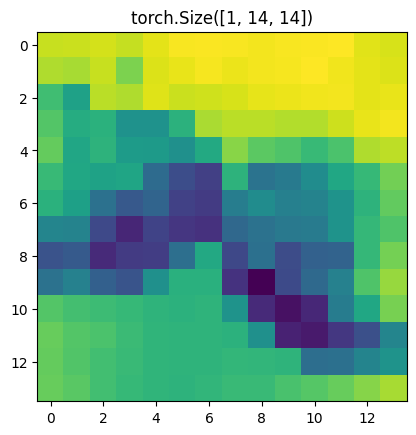

In [14]:
sample=conv2d(image.unsqueeze(0))
sample1=sample[:,767,:,:]
plt.imshow(sample1.squeeze(0).detach().numpy())
plt.title(sample1.shape)

#below is the 768th feature of all 14 patches

In [15]:
#convert them into sequential!
from torch import nn

flatten_layer =nn.Flatten(start_dim=2,end_dim=3) 

#start_dim=2 ==> [1,768,14,14] =>14
#end_dim=3 ==> [1,768,14,14] =>14    finally 14*14=196

flattened_feature_map=flatten_layer(sample)
flattened_feature_map.shape

torch.Size([1, 768, 196])

Text(0.5, 1.0, 'flattened feature map')

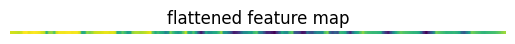

In [16]:
flattened_feature_map_permuted=flattened_feature_map.permute(0,2,1)
flattened_feature_map_permuted=flattened_feature_map_permuted.detach().numpy()
plt.imshow(flattened_feature_map_permuted[:,:,765])
plt.axis('off')
plt.xticks([])      
plt.yticks([])
plt.title("flattened feature map")

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, embedding_size=768, patch_size=16):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels, embedding_size, kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x_patched = self.patcher(x)             
        x_flattened = self.flatten(x_patched)    
        return x_flattened.permute(0, 2, 1)   

In [18]:

patchify=PatchEmbedding(in_channels=3,
                         embedding_size=768,
                         patch_size=16)
patched_flattened_image=patchify(image.unsqueeze(0))

In [19]:
#now create class token embeddings ....

#prepend a value to every image tensor....196+1=197

#this token learns about the entire image and after applying softmax,
#it will give probabilities to classify the image

#so the tensor size will become 196+1=197



In [20]:
learnables=torch.ones((1,1,768),requires_grad=True) #create 

class_tokens=nn.Parameter(learnables,requires_grad=True)

print(class_tokens.shape)

patched_flattened_image_class=torch.cat((class_tokens,patched_flattened_image),dim=1)
patched_flattened_image_class.shape



torch.Size([1, 1, 768])


torch.Size([1, 197, 768])

add spatial tokens....

when image is flattened the order o the image is forgetten...

so we should also create learnable for the spatial representaions...

as per the research paper formula...it will be added to the last....

In [21]:
spatial_learnables=torch.ones((1,197,768),requires_grad=True) #create 

spatial_class_tokens=nn.Parameter(spatial_learnables,requires_grad=True)

patched_flattened_image_class_spatial=patched_flattened_image_class+spatial_class_tokens

patched_flattened_image_class_spatial.shape


#here 197 because each has patches(197 in total) has each position

torch.Size([1, 197, 768])

steps..

create tensor full of ones and prepend to the tensor using cat

create a parameter with nn.paramter

In [22]:
torch.manual_seed(42)

patch_size=16

x=image.unsqueeze(0)
patch_embedding_layer=PatchEmbedding(in_channels=3,
                                             embedding_size=768,
                                             patch_size=patch_size)
patch_embedding=patch_embedding_layer(x)

batch_size=patch_embedding.shape[0]
embedding_dimension=patch_embedding.shape[2]


class_token=nn.Parameter(torch.ones((batch_size,1,embedding_dimension)),
                         requires_grad=True)

patch_embedding_class=torch.cat((class_token,patch_embedding),dim=1)

num_patches=196

spatial_tokens=nn.Parameter(torch.ones((batch_size,num_patches+1,embedding_dimension)),
                         requires_grad=True)

patch_position_embedding=patch_embedding_class+spatial_tokens


#self attention layer


how much a patch should pay attention to another patch...

[query, key ,value] are the attributes the attention


it want to learn relationship between patches...


heads in multi-head self attention layer:


if heads = 8 ....it learns 8 different relationships b/w patches
eg: colour ,edge,et...

In [23]:
class multihead(nn.Module):
    def __init__(self,embedding_dim:int=768,
                 num_heads:int=8,
                 dropout:float=0.1):
        super().__init__()
        
        self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
        
        #msa
        self.multihead=nn.MultiheadAttention(embed_dim=embedding_dim,
                                             num_heads=num_heads,
                                             batch_first=True)#gives in batch ,seq , feature format
        
    def forward(self,x):
        x=self.layer_norm(x)
        attention_output,attention_weights=self.multihead(x,x,x)#qkv
        
        return attention_output

In [24]:
msa=multihead(embedding_dim=768,
                 num_heads=8,
                 dropout=0.1)
msa_output=msa(patched_flattened_image_class_spatial)


MLP BLOCK

gelu activation should be used

In [25]:
class mlp_block(nn.Module):
    def __init__(self,input_dim:int=768,
                 hidden_dim:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        self.norm=nn.LayerNorm(normalized_shape=input_dim)
        
        self.mlp=nn.Sequential(nn.Linear(in_features=input_dim,
                           out_features=hidden_dim),
                               nn.GELU(),
                               nn.Dropout(p=dropout),
                               nn.Linear(in_features=hidden_dim,
                                         out_features=input_dim),
                               nn.Dropout(p=dropout))

    def forward(self,x):
        x=self.norm(x)
        x=self.mlp(x)
        return x
        

In [26]:
mlp=mlp_block(input_dim=768,
                 hidden_dim=3072,
                 dropout=0.1)
mlp_output=mlp(msa_output)

in paper:

encoder layer:

input->msa->(msa output+input) ->mlp ->(msa output+mlp input) 

In [27]:
class transformer_block(nn.Module):
    def __init__(self,embedding_dim:int = 768,
                 num_heads:int=12,
                 hidden_dim:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        self.msa=multihead(embedding_dim=embedding_dim,
                           num_heads=num_heads,
                           dropout=dropout)
        
        self.mlp=mlp_block(input_dim=embedding_dim,
                           hidden_dim=hidden_dim,
                           dropout=dropout)
        
    def forward(self,x):
        x=self.msa(x)+x  #from formula
        x=self.mlp(x)+x
        return x
            

In [28]:
import torchinfo
transformer=transformer_block(embedding_dim=768,
                            num_heads=12,
                            hidden_dim=3072,
                            dropout=0.1)

summary= torchinfo.summary(transformer,
                           input_size=(1,197,768),
                        
                           col_names=["input_size","output_size","num_params","trainable"],
                           row_settings=["var_names"],
                           )
summary

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
transformer_block (transformer_block)         [1, 197, 768]             [1, 197, 768]             --                        True
├─multihead (msa)                             [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention (multihead)         [1, 197, 768]             [1, 197, 768]             2,362,368                 True
├─mlp_block (mlp)                             [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (norm)                       [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential (mlp)                       [1, 197, 768]             [1, 197, 768]       

for now...its the architecture we built from scratch....

now we gonna build it using pytorch inbuilt layers

#we can create transformer encoder layer using pytorch

In [29]:
torch_transformer_layer=nn.TransformerEncoderLayer(d_model=768,
                                                   nhead=12,
                                                   dim_feedforward=3072,
                                                   dropout=0.1,
                                                   batch_first=True)
torchinfo.summary(torch_transformer_layer)

Layer (type:depth-idx)                             Param #
TransformerEncoderLayer                            --
├─MultiheadAttention: 1-1                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
├─Linear: 1-2                                      2,362,368
├─Dropout: 1-3                                     --
├─Linear: 1-4                                      2,360,064
├─LayerNorm: 1-5                                   1,536
├─LayerNorm: 1-6                                   1,536
├─Dropout: 1-7                                     --
├─Dropout: 1-8                                     --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

Creating a complete vision transformer

In [30]:
import torch
import torch.nn as nn



class ViT(nn.Module):
    def __init__(self,
                 img_size: int = 224,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_blocks: int = 12,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 num_heads: int = 12,
                 attn_dropout: float = 0,
                 mlp_dropout: float = 0.1,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 1000):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2

        self.patch_embedding =PatchEmbedding(
            in_channels=in_channels,
            embedding_size=embedding_dim,
            patch_size=patch_size
        )
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.positional_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, embedding_dim)
        )
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.transformer = nn.Sequential(
            *[transformer_block(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                hidden_dim=mlp_size,
                dropout=attn_dropout
            ) for _ in range(num_transformer_blocks)]
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        patch_embeddings = self.patch_embedding(x) 
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        x = torch.cat((class_token, patch_embeddings), dim=1)  
        x = x + self.positional_embedding
        x = self.embedding_dropout(x)
        x = self.transformer(x)

        
        class_output = x[:, 0]  
        return self.classifier(class_output)


In [31]:
image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT()
vit_output = vit(image_tensor)
vit_output

tensor([[-7.2286e-02,  8.0297e-01, -1.7319e-01, -4.1370e-01,  4.1530e-02,
         -1.8497e-01,  1.2035e-01, -1.2032e+00,  8.5092e-01, -3.1812e-01,
          1.1898e-01,  4.2244e-01, -6.5320e-02, -7.6194e-01,  5.0086e-01,
         -7.5092e-02,  1.3535e-01,  9.6219e-02, -1.0129e-01,  7.7971e-01,
         -3.3860e-01, -9.8575e-01, -2.3600e-02, -3.6677e-01,  2.3925e-01,
          1.3809e-01, -6.5911e-01,  3.9546e-01,  4.2196e-01, -9.1674e-01,
          1.0498e+00,  1.2549e-01, -6.6884e-01,  2.7782e-01,  2.2057e-01,
         -5.6874e-02,  4.1898e-01, -4.4700e-02, -1.3909e+00, -3.9356e-01,
         -4.7249e-01,  7.4064e-01,  7.6266e-01, -6.7145e-01, -3.4214e-01,
          8.5119e-02, -7.9193e-01, -3.2553e-01, -4.4318e-01,  6.6773e-02,
          8.0081e-01, -3.5888e-01, -8.9100e-02, -5.0810e-01,  2.3928e-01,
          4.0136e-01, -2.6385e-01, -6.5552e-02, -6.9215e-02,  3.0460e-01,
          2.5026e-01, -2.8202e-01,  6.2891e-01, -5.7895e-02, -4.1711e-01,
          2.3712e-01, -9.3855e-01, -6.

In [32]:
from torchinfo import summary
vit=ViT()
print(summary(vit))


Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─PatchEmbedding: 1-1                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Dropout: 1-2                                                    --
├─Sequential: 1-3                                                 --
│    └─transformer_block: 2-3                                     --
│    │    └─multihead: 3-1                                        2,363,904
│    │    └─mlp_block: 3-2                                        4,723,968
│    └─transformer_block: 2-4                                     --
│    │    └─multihead: 3-3                                        2,363,904
│    │    └─mlp_block: 3-4                                        4,723,968
│    └─transformer_block: 2-5                               

In [33]:
optimizer=torch.optim.Adam(params=vit.parameters(),
                           lr=1e-3,betas=(0.9,0.999),
                           weight_decay=0.01)
#the above mentioned are the parameters of
# the optimizer mentioned in the research paper
loss_fn=nn.CrossEntropyLoss()

In [34]:
from going_modular import engine

results=engine.train(model=vit,
             train_dataloader=train_dataloader,
             test_dataloader=test_data_loader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=3
             )

 33%|███▎      | 1/3 [01:42<03:25, 102.52s/it]

Epoch: 0 | Train loss: 3.3631 | Train acc: 0.4023 | Test loss: 1.2154 | Test acc: 0.5417


 67%|██████▋   | 2/3 [03:20<01:40, 100.11s/it]

Epoch: 1 | Train loss: 1.3381 | Train acc: 0.3828 | Test loss: 1.2386 | Test acc: 0.2604


100%|██████████| 3/3 [05:01<00:00, 100.57s/it]

Epoch: 2 | Train loss: 1.2131 | Train acc: 0.3008 | Test loss: 1.1254 | Test acc: 0.5417


1) low accuracy due to less data..because the model uses millions of images
2) learning rate warmup and learning rate decay are hyperparameters that we should use

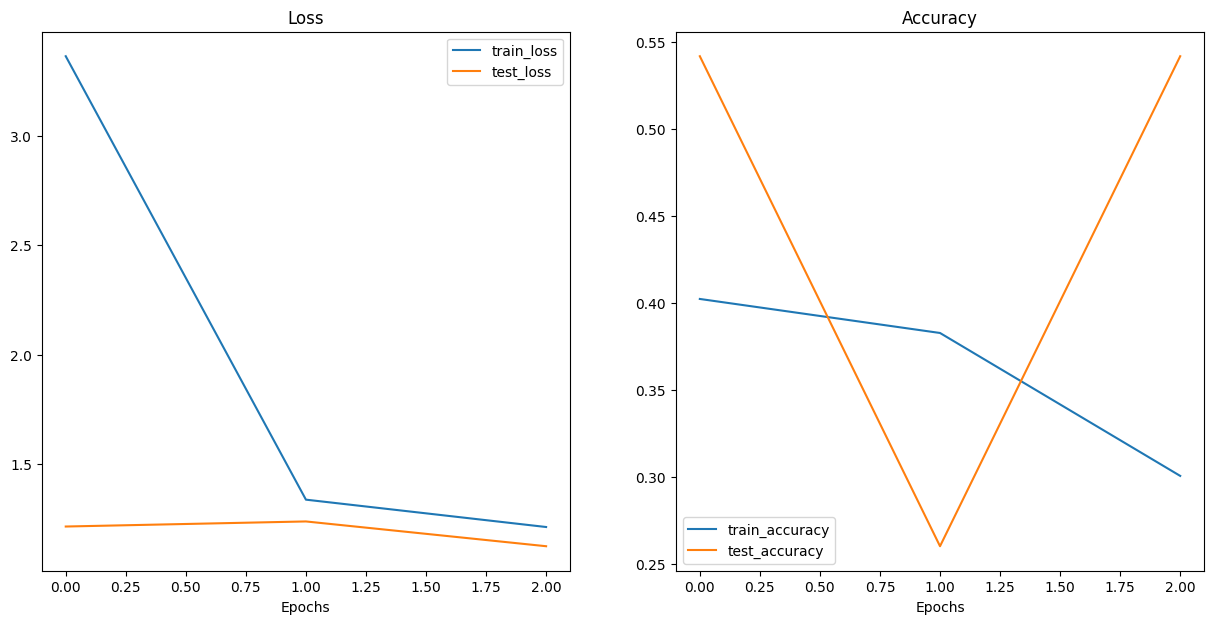

In [35]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=results)

In [36]:
#use transfer learning now
#use pretrained weights

In [37]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0
0.21.0


In [38]:
weights=torchvision.models.ViT_B_16_Weights.DEFAULT

vit_pretrained=torchvision.models.vit_b_16(weights=weights) 

for param in vit_pretrained.parameters():
    param.requires_grad=False

vit_pretrained.heads=nn.Linear(in_features=768,
                                         out_features=3,)


In [39]:
summary(vit_pretrained)

transforms=weights.transforms()

transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [40]:
from going_modular import data_setup

train_dataloader,test_data_loader,class_names=data_setup.create_dataloaders(train_dir='data/pizza_steak_sushi/train',
                              test_dir='data/pizza_steak_sushi/test',
                              batch_size=32,
                              transform=transforms)


In [41]:
import torch
from going_modular import  engine
optimizer=torch.optim.Adam(params=vit_pretrained.parameters(),
                           lr=1e-3,betas=(0.9,0.999),
                           weight_decay=0.01)
loss_fn=nn.CrossEntropyLoss()
results=engine.train(model=vit_pretrained,
             train_dataloader=train_dataloader,
             test_dataloader=test_data_loader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=3
             )

 33%|███▎      | 1/3 [00:54<01:48, 54.10s/it]

Epoch: 0 | Train loss: 0.8768 | Train acc: 0.6094 | Test loss: 0.5175 | Test acc: 0.7964


 67%|██████▋   | 2/3 [01:46<00:53, 53.25s/it]

Epoch: 1 | Train loss: 0.4451 | Train acc: 0.9258 | Test loss: 0.3471 | Test acc: 0.9081


100%|██████████| 3/3 [02:39<00:00, 53.09s/it]

Epoch: 2 | Train loss: 0.2361 | Train acc: 0.9609 | Test loss: 0.2536 | Test acc: 0.9280


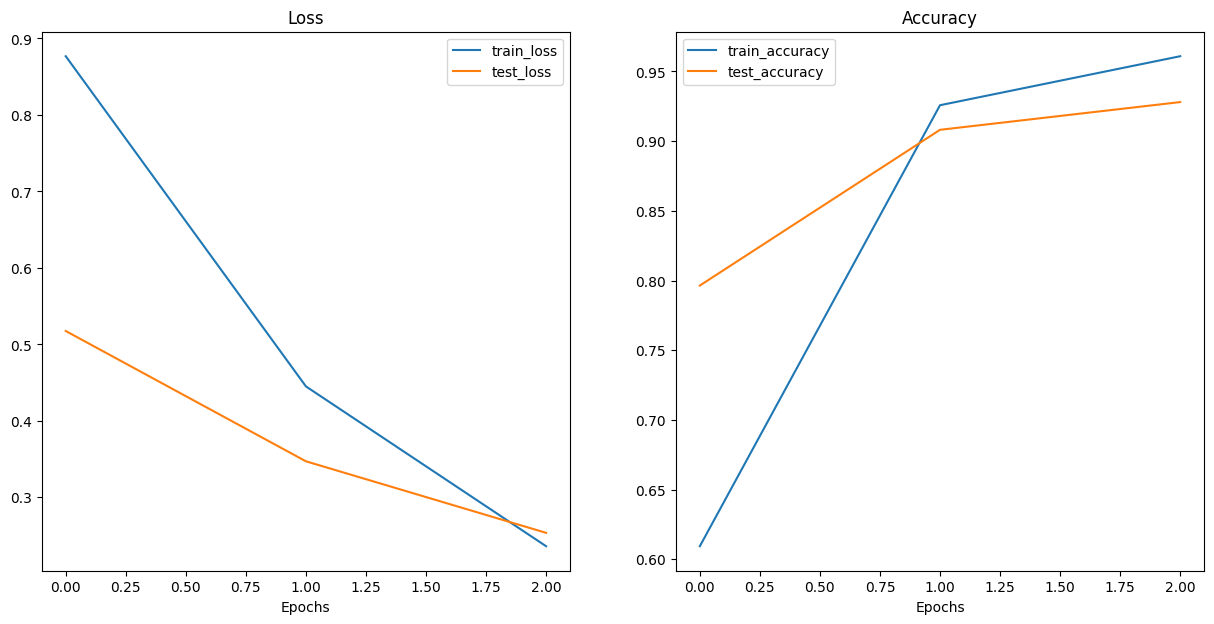

In [42]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=results)

In [43]:
torch.save(vit_pretrained.state_dict(),"pretrained_vit.pth")

In [44]:
from pathlib import Path
size_model=Path("pretrained_vit.pth").stat().st_size
size_model/(1024*1024)

327.3612117767334

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


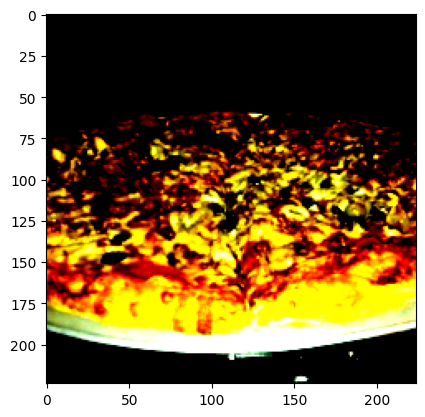

In [45]:
image=test_data_loader.dataset[0][0].permute(1,2,0)
plt.imshow(image)


In [50]:
from PIL import Image
from torchvision import transforms

# Define the transform
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_path = 'testing_images/istockphoto-1442417585-612x612.jpg'
img = Image.open(image_path).convert('RGB')  
tensor_image = transform(img)






FileNotFoundError: [Errno 2] No such file or directory: 'testing_images/istockphoto-1442417585-612x612.jpg'

In [47]:
prediction=vit_pretrained(tensor_image.unsqueeze(0))
soft=torch.nn.Softmax()
predictions=soft(prediction)
label=predictions.argmax()
print(class_names[label])

NameError: name 'tensor_image' is not defined

In [48]:
from torchvision.datasets import ImageFolder
image_data=ImageFolder(root='testing_images',transform=transforms)

secondone=vit_pretrained(image_data[1][0].unsqueeze(0))
soft=torch.nn.Softmax()
predictions=soft(secondone)
label=predictions.argmax()  
print(class_names[label])

sushi


/Users/jaswanthb/.local/share/virtualenvs/jaswanthb-71VjwBC8/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
